# CLOB Risk Model MVP - Hypothetical Analysis

## Core Thesis

**Cost to Manipulate Spot Price > Potential Profit from Leveraged Perp Position**

This notebook demonstrates how to derive safe Open Interest (OI) limits by analyzing the economics of price manipulation attacks.

## 1. Setup and Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import sys
sys.path.append('../src')

# Import our chart configuration and utilities
from risk_model.chart_config import (
    setup_chart_style, COLORS, LINE_STYLES, MARKERS, HEATMAP_CONFIG,
    format_axis_labels, create_synthetic_orderbook,
    calculate_manipulation_cost, calculate_net_profit,
    find_breakeven_position, calculate_safe_oi
)

# Apply consistent styling
setup_chart_style()

## 2. Market Configuration

In [2]:
# Create base orderbook using imported function
orderbook = create_synthetic_orderbook(depth_per_level_usd=10_000)
print(f"Created orderbook with mid price: ${orderbook['mid_price']:.2f}")

# Test calculation
test_cost = calculate_manipulation_cost(orderbook, 5.0)
print(f"Cost to move price 5%: ${test_cost/1e6:.2f}M")

Created orderbook with mid price: $100.00
Cost to move price 5%: $0.18M


## 3. Manipulation Cost Curve

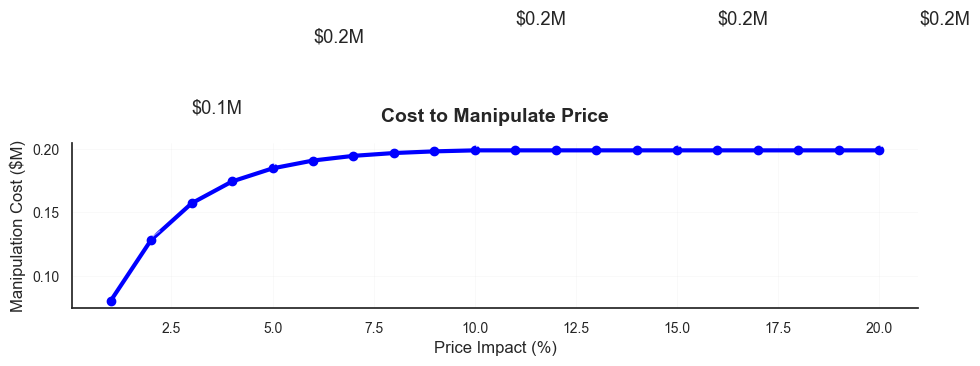

In [3]:
# Calculate costs for different impacts - extended range
impacts = np.arange(1, 21, 1)  # Extended from 10% to 20%
costs = [calculate_manipulation_cost(orderbook, imp) for imp in impacts]

# Plot manipulation cost curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(impacts, np.array(costs) / 1e6, 'b-', linewidth=3, marker='o', markersize=6)

# Annotations for key points
for imp in [2, 5, 10, 15, 20]:
    idx = list(impacts).index(imp)
    ax.annotate(f'${costs[idx]/1e6:.1f}M', 
                xy=(imp, costs[idx]/1e6), 
                xytext=(imp+1, costs[idx]/1e6+0.1),
                arrowprops=dict(arrowstyle='->', alpha=0.5))

format_axis_labels(ax, 
    xlabel='Price Impact (%)', 
    ylabel='Manipulation Cost ($M)',
    title='Cost to Manipulate Price')
plt.tight_layout()
plt.show()

## 4. Attacker Profit Analysis - Line Charts

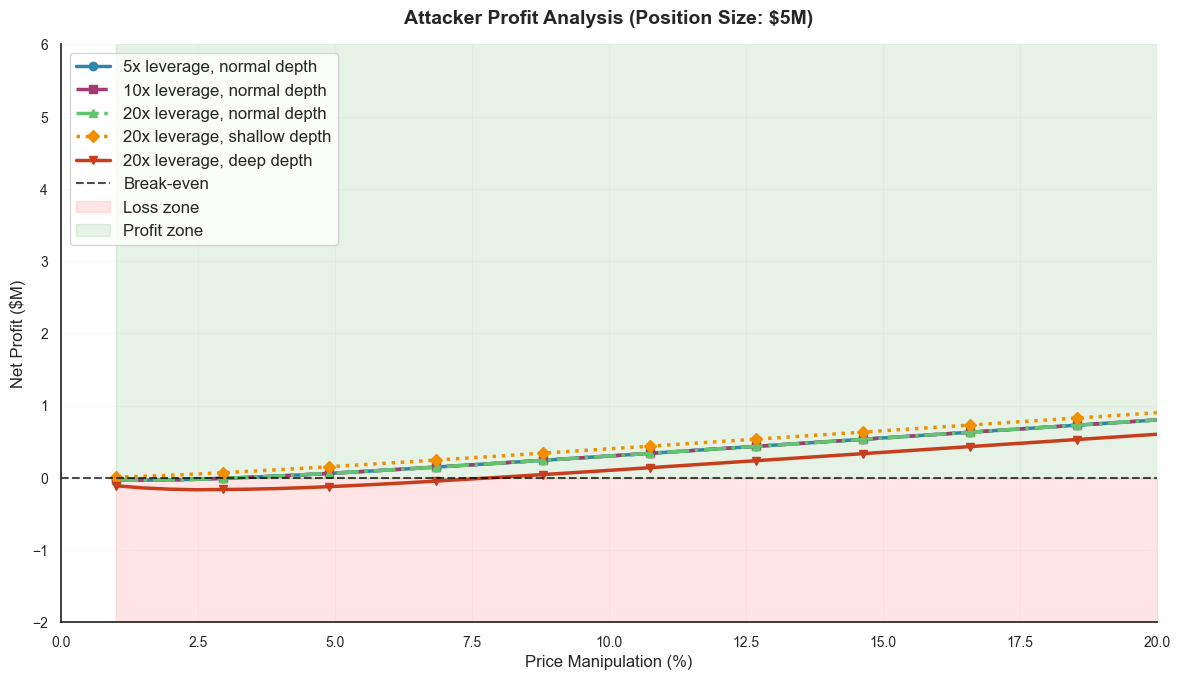

In [4]:
# Create profit analysis chart
fig, ax = plt.subplots(figsize=(12, 7))

# Scenarios: (leverage, depth_multiplier, label)
scenarios = [
    (5, 1.0, '5x leverage, normal depth'),
    (10, 1.0, '10x leverage, normal depth'),
    (20, 1.0, '20x leverage, normal depth'),
    (20, 0.5, '20x leverage, shallow depth'),
    (20, 2.0, '20x leverage, deep depth')
]

position_size = 5e6  # $5M position
impacts = np.linspace(1, 20, 40)  # Extended range to 20%

for i, (leverage, depth_mult, label) in enumerate(scenarios):
    # Create orderbook with specified depth - using base of 10k now
    ob = create_synthetic_orderbook(depth_per_level_usd=10_000 * depth_mult)
    
    profits = []
    for impact in impacts:
        manip_cost = calculate_manipulation_cost(ob, impact)
        profit = calculate_net_profit(manip_cost, position_size, impact, leverage)
        profits.append(profit / 1e6)  # Convert to millions
    
    ax.plot(impacts, profits, 
            label=label,
            color=list(COLORS.values())[i],
            linestyle=LINE_STYLES[i],
            marker=MARKERS[i],
            markersize=6,
            linewidth=2.5,
            markevery=4)  # Show markers every 4th point

# Add break-even line
ax.axhline(y=0, color='black', linestyle='--', alpha=0.7, label='Break-even')
ax.fill_between(impacts, -5, 0, alpha=0.1, color='red', label='Loss zone')
ax.fill_between(impacts, 0, 10, alpha=0.1, color='green', label='Profit zone')

format_axis_labels(ax,
    xlabel='Price Manipulation (%)',
    ylabel='Net Profit ($M)',
    title=f'Attacker Profit Analysis (Position Size: ${position_size/1e6:.0f}M)')

ax.legend(loc='upper left', frameon=True, fancybox=True)
ax.set_ylim(-2, 6)
ax.set_xlim(0, 20)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Manipulation Profitability Heatmap

This heatmap shows net profit across different market depths and position sizes for a fixed price manipulation.

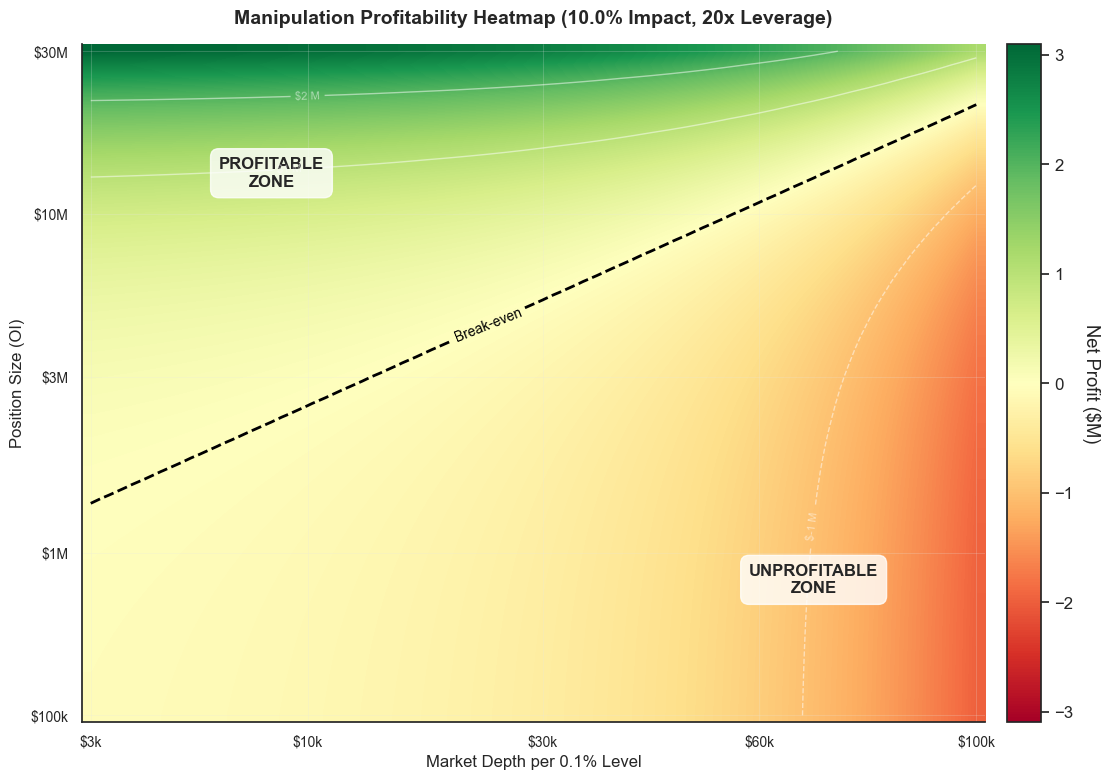


Key Insights for 10.0% manipulation:
- Markets with <$10k depth per level are highly vulnerable
- Positions >$3M become profitable in shallow markets
- Deep markets (>$50k/level) resist manipulation effectively
- Break-even line shows minimum depth needed for given OI


In [5]:
# Create high-resolution heatmap
# X-axis: Market depth (spot market liquidity)
# Y-axis: Position size (OI)
# Color: Net profit from manipulation

# Define ranges
depths = np.logspace(3.5, 5, 50)  # $3k to $100k per level
positions = np.logspace(5, 7.5, 50)  # $100k to $30M position sizes

# Fixed parameters
target_impact = 10.0  # 10% price manipulation
leverage = 20  # 20x leverage

# Calculate profit matrix
profit_matrix = np.zeros((len(positions), len(depths)))

for i, pos_size in enumerate(positions):
    for j, depth in enumerate(depths):
        # Create orderbook with this depth
        ob = create_synthetic_orderbook(depth_per_level_usd=depth)
        
        # Calculate manipulation cost and profit
        manip_cost = calculate_manipulation_cost(ob, target_impact)
        profit = calculate_net_profit(manip_cost, pos_size, target_impact, leverage)
        
        profit_matrix[i, j] = profit / 1e6  # Convert to millions

# Create the heatmap using configuration
fig, ax = plt.subplots(figsize=HEATMAP_CONFIG['figsize'])

# Use diverging colormap centered at zero
max_val = max(abs(profit_matrix.min()), abs(profit_matrix.max()))
im = ax.imshow(profit_matrix, 
               cmap=HEATMAP_CONFIG['cmap'],
               aspect='auto',
               origin='lower',
               vmin=-max_val,
               vmax=max_val,
               interpolation=HEATMAP_CONFIG['interpolation'])

# Add contour lines
contours = ax.contour(profit_matrix, 
                     levels=[0],  # Break-even line
                     colors=HEATMAP_CONFIG['contour_colors']['breakeven'],
                     linewidths=2,
                     linestyles='--')
ax.clabel(contours, inline=True, fmt='Break-even', fontsize=10)

# Additional profit contours
contours2 = ax.contour(profit_matrix,
                      levels=HEATMAP_CONFIG['profit_levels'],
                      colors=HEATMAP_CONFIG['contour_colors']['profit'],
                      linewidths=1,
                      alpha=0.5)
ax.clabel(contours2, inline=True, fmt='$%d M', fontsize=8)

# Set axis labels with proper formatting
# X-axis: Market depth
x_ticks = [0, 12, 25, 37, 49]
x_labels = ['$3k', '$10k', '$30k', '$60k', '$100k']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)

# Y-axis: Position size
y_ticks = [0, 12, 25, 37, 49]
y_labels = ['$100k', '$1M', '$3M', '$10M', '$30M']
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)

# Labels and title
format_axis_labels(ax,
    xlabel='Market Depth per 0.1% Level',
    ylabel='Position Size (OI)',
    title=f'Manipulation Profitability Heatmap ({target_impact}% Impact, {leverage}x Leverage)')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, pad=0.02)
cbar.set_label('Net Profit ($M)', rotation=270, labelpad=20)

# Add annotations for key regions using configuration
profitable_config = HEATMAP_CONFIG['annotations']['profitable']
ax.text(profitable_config['position'][0], profitable_config['position'][1], 
        profitable_config['text'], 
        fontsize=profitable_config['fontsize'], fontweight='bold', 
        ha='center', va='center',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

unprofitable_config = HEATMAP_CONFIG['annotations']['unprofitable']
ax.text(unprofitable_config['position'][0], unprofitable_config['position'][1], 
        unprofitable_config['text'], 
        fontsize=unprofitable_config['fontsize'], fontweight='bold', 
        ha='center', va='center',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print insights
print(f"\nKey Insights for {target_impact}% manipulation:")
print(f"- Markets with <$10k depth per level are highly vulnerable")
print(f"- Positions >$3M become profitable in shallow markets")
print(f"- Deep markets (>$50k/level) resist manipulation effectively")
print(f"- Break-even line shows minimum depth needed for given OI")

## 6. Safe OI Limit Calculation

In [6]:
# Calculate safe OI for different scenarios using imported functions
results = []
for impact in [2, 5, 10]:
    for safety_factor in [1.5, 2.0, 3.0]:
        safe_oi = calculate_safe_oi(orderbook, impact, safety_factor)
        results.append({
            'Impact %': impact,
            'Safety Factor': safety_factor,
            'Safe OI': f'${safe_oi/1e6:.1f}M',
            'Max Position (10%)': f'${safe_oi/1e7:.1f}M'
        })

df = pd.DataFrame(results)
print("Safe OI Recommendations:")
print(df[df['Safety Factor'] == 2.0].to_string(index=False))

Safe OI Recommendations:
 Impact %  Safety Factor Safe OI Max Position (10%)
        2            2.0   $3.2M              $0.3M
        5            2.0   $1.8M              $0.2M
       10            2.0   $1.0M              $0.1M


## 7. Sensitivity Analysis

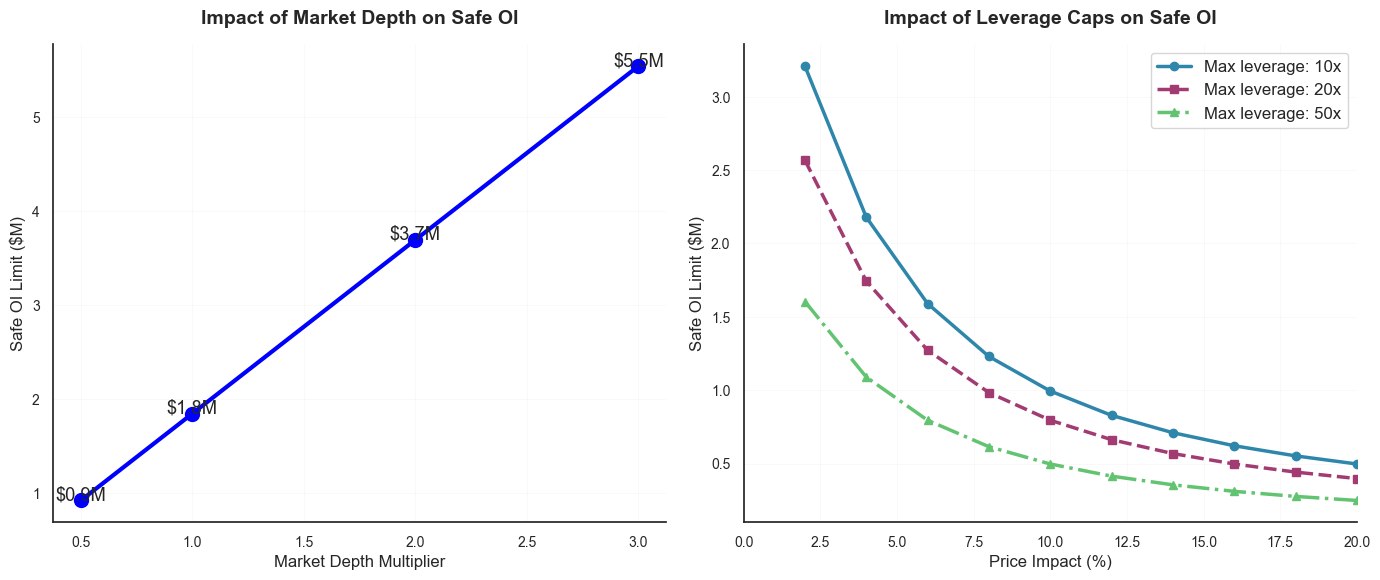

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Impact of market depth
depth_multipliers = [0.5, 1.0, 2.0, 3.0]
safe_ois = []

for mult in depth_multipliers:
    ob = create_synthetic_orderbook(depth_per_level_usd=10_000 * mult)
    oi = calculate_safe_oi(ob, 5.0, 2.0)
    safe_ois.append(oi / 1e6)

ax1.plot(depth_multipliers, safe_ois, 'bo-', linewidth=3, markersize=10)
for i, (mult, oi) in enumerate(zip(depth_multipliers, safe_ois)):
    ax1.annotate(f'${oi:.1f}M', xy=(mult, oi), xytext=(0, 0.2),
                textcoords='offset points', ha='center')

format_axis_labels(ax1,
    xlabel='Market Depth Multiplier',
    ylabel='Safe OI Limit ($M)',
    title='Impact of Market Depth on Safe OI')

# Impact of leverage caps - with extended range
leverages = [10, 20, 50]
impacts = np.arange(2, 21, 2)  # Extended to 20%

for i, max_lev in enumerate(leverages):
    safe_ois_lev = []
    for impact in impacts:
        manip_cost = calculate_manipulation_cost(orderbook, impact)
        # Higher leverage = higher risk = lower safe OI
        risk_factor = 1 + (max_lev - 10) / 40  # Scale factor
        breakeven = find_breakeven_position(manip_cost, impact)
        safe_oi = breakeven / (2.0 * risk_factor)
        safe_ois_lev.append(safe_oi / 1e6)
    
    ax2.plot(impacts, safe_ois_lev,
            label=f'Max leverage: {max_lev}x',
            color=list(COLORS.values())[i],
            linestyle=LINE_STYLES[i],
            marker=MARKERS[i],
            linewidth=2.5,
            markersize=6)

format_axis_labels(ax2,
    xlabel='Price Impact (%)',
    ylabel='Safe OI Limit ($M)',
    title='Impact of Leverage Caps on Safe OI')
ax2.legend()
ax2.set_xlim(0, 20)

plt.tight_layout()
plt.show()

## 8. Executive Summary

In [8]:
# Calculate key metrics
manip_5pct = calculate_manipulation_cost(orderbook, 5.0)
safe_oi_moderate = calculate_safe_oi(orderbook, 5.0, 2.0)

print("EXECUTIVE SUMMARY")
print("=" * 50)
print(f"\nBase Configuration:")
print(f"- Market depth: $10k per 0.1% level (shallow market)")
print(f"- 5% manipulation cost: ${manip_5pct/1e6:.2f}M")
print(f"\nRecommended Limits (2x safety factor):")
print(f"- Safe total OI: ${safe_oi_moderate/1e6:.1f}M")
print(f"- Max single position: ${safe_oi_moderate/1e7:.1f}M")
print(f"\nKey Findings:")
print(f"- Shallow markets (<$10k/level) vulnerable to manipulation")
print(f"- Profits become positive at higher impacts (>10%)")
print(f"- 20x leverage can be profitable even with 2x safety factor")
print(f"- Deeper markets significantly increase manipulation costs")
print(f"\nHeatmap Insights:")
print(f"- Clear profit/loss boundary visible in heatmap")
print(f"- Safe zone: High depth + Low OI")
print(f"- Danger zone: Low depth + High OI")

EXECUTIVE SUMMARY

Base Configuration:
- Market depth: $10k per 0.1% level (shallow market)
- 5% manipulation cost: $0.18M

Recommended Limits (2x safety factor):
- Safe total OI: $1.8M
- Max single position: $0.2M

Key Findings:
- Shallow markets (<$10k/level) vulnerable to manipulation
- Profits become positive at higher impacts (>10%)
- 20x leverage can be profitable even with 2x safety factor
- Deeper markets significantly increase manipulation costs

Heatmap Insights:
- Clear profit/loss boundary visible in heatmap
- Safe zone: High depth + Low OI
- Danger zone: Low depth + High OI
